In [1]:
import numpy as np
import scipy as sci
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import librosa
from librosa import display
import IPython
import collections
import jams
import string
import re
import sklearn 
from sklearn import preprocessing

In [2]:
# track tempo estimate
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

NameError: name 'y' is not defined

In [ ]:
import itertools
def head(dict_, n):
    return dict(itertools.islice(dict_.items(), n))

In [ ]:
def exportJAM(sound_file, fail_dict, out_file):
    # Construct a new JAMS object and new annotation records
    jam = jams.JAMS()
    
    # Get the file metadata
    title = sound_file.split('/')[3].split('.')[0]
    artist = sound_file.split('/')[2].split('_')[0]
    release = sound_file.split('/')[2].split('_')[2]
    
    # Load the audio file
    y, sr = librosa.load(sound_file)

    # Get the track duration
    track_duration = librosa.get_duration(y=y, sr=sr)
    track_duration = '%.2f' % (float(track_duration))
    
    jam.file_metadata.duration = float(track_duration)
    jam.file_metadata.title = title
    jam.file_metadata.artist = artist
    jam.file_metadata.release = release
    
    fail_lyrics = jams.Annotation(namespace='lyrics', time=0) # what does time mean in this context?
    fail_lyrics.annotation_metadata = jams.AnnotationMetadata(data_source='Collecive Rap Datasets')
    
    for failling in fail_dict:
        interval = list(failling.keys())[0].split('-')
        start_time = float(interval[0])
        duration = float(interval[1]) - float(interval[0])
        duration = float('%.2f' % duration)
        
        fail_words = ''
        for f_word in list(failling.values())[0]:
            fail_words += f_word[0] + ' '
        
        fail_words = fail_words.rstrip()
        fail_lyrics.append(time=start_time, duration=duration, value=fail_words)
    
    jam.annotations.append(fail_lyrics)
    jam.save(out_file)

In [ ]:
exportJAM(sound_file, fail_dict, out_file="test.jams")

In [3]:
# visualization with fail nums
# keys = []
# nums = []
# fail_num_lst = fail_nums[:]
# for f in fail_num_lst:
#     key = f[0]
#     num = f[1]
#     keys.append(key)
#     nums.append(num)

In [4]:
# x = np.arange(len(nums))
# plt.figure(figsize=(25,15))
# plt.bar(x, height=nums)
# plt.xlabel('Words failed to be aligned', fontsize=25)
# locs, labels = plt.xticks(x, keys, rotation=90, fontsize= 20)

In [5]:
# Record the numbers of failling phonemes, try to visualize them (together with the <unk>)

# fail_phoneme_num = {}
# for k in keys:
#     if k in phoneme_dict:
#         for pho in phoneme_dict[k]:
#             if pho in fail_phoneme_num:
#                 fail_phoneme_num[pho] += 1
#             else:
#                 fail_phoneme_num[pho] = 1
#     else:
#         unknown = '<unk>'
#         if unknown in fail_phoneme_num:
#                 fail_phoneme_num[unknown] += 1
#         else:
#             fail_phoneme_num[unknown] = 1

In [6]:
# fail_phonemes_sorted = sorted(fail_phoneme_num.items(), key=lambda kv: kv[1], reverse=True)

In [7]:
# fail_phonemes = [v[0] for v in fail_phonemes_sorted]
# fail_phonemes_count = [v[1] for v in fail_phonemes_sorted]

In [8]:
# plot the failed phonemes
# x = np.arange(len(fail_phonemes))
# plt.figure(figsize=(25,15))
# plt.bar(x, height=fail_phonemes_count)
# plt.xlabel('Phonemes failed to be aligned', fontsize=25)
# locs, labels = plt.xticks(x, fail_phonemes, rotation=90, fontsize= 20)

In [9]:
# 模块化
# Goal: to see how well the alginment tool works

In [3]:
import os
from os import walk

In [140]:
# helper function for reading phoneme dictionaries
def phoneme_dict_reader(phoneme_dict_file):
    with open(phoneme_dict_file, 'r') as reader:
        lines = reader.readlines()
    
    phoneme_dict = dict()
    # extract each individual phoneme
    for line in lines:
        line = line.split()
        phoneme_dict[line[0].lower()] = line[1:]
        
    return phoneme_dict

# test
res = phoneme_dict_reader('cmudict.txt')


# construct the phoneme set 
phone_set = set()
max_phone_len = 0
for phonemes in res.values():
    max_phone_len = max(max_phone_len, len(phonemes))
    for phone in phonemes:
        phone_set.add(phone.upper())

In [5]:
# 1. 构造compute_fail_num函数 (focus on word level)
def compute_fail_nums(path, errorRate_over_tracks):
    
    # get the track_name
    # find '/'
    start_idx = path.find('/', 8)
    track_name = path[start_idx + 1:-4] # corresponding to specific path format
    
    # read the aligned file
    with open(path, 'r') as reader:
    #     lines = reader.readlines()
        aligned_lines = json.load(reader)
        
    # compute
    # trascript
    transcript = aligned_lines['transcript']
    words = aligned_lines['words']
    
    case = 'case'
    fails = [words[i] for i in range(len(words)) if words[i][case] == 'not-found-in-audio']
    
    # 这里的话就是一个初筛
    fail_ratio = len(fails) / len(words)
    errorRate_over_tracks[track_name] = '{:.2%}'.format(fail_ratio)

In [6]:
def compute_aggregate(path, errorRate_over_tracks):
    # test on 5 algined files
    folder_prefix = path
    
    # get all the folders
    dirs = [d for d in os.listdir(folder_prefix) if os.path.isdir(folder_prefix + d) and d != '.ipynb_checkpoints']
    
    album_paths = []
    for album in dirs:
        album_paths.append(folder_prefix + album)
        
    for album_path in album_paths:
        aligned_files = [album_path + '/' + f for f in os.listdir(album_path) if os.path.isfile(album_path + '/' + f) and f.startswith('.DS') == False]
        for aligned_file in aligned_files:
            compute_fail_nums(aligned_file, errorRate_over_tracks)

    # sort the error rate based on error rate
    errorRate_over_tracks_sorted = sorted(errorRate_over_tracks.items(), key=lambda kv: float(kv[1].strip('%'))/100)
    
    # according to the threshold, select some workable tracks
    filtered_tracks = list(filter(select_tracks, errorRate_over_tracks_sorted))
    
    return filtered_tracks

In [7]:
def select_tracks(track):
    if float(track[1].strip('%')) / 100 < 0.18:  # 0.18 as threshold
        return True
    else:
        return False

In [8]:
# collection info of error rate for each tracks
errorRate_over_tracks = {}

In [9]:
compute_aggregate('data/aligned/', errorRate_over_tracks)

[('Criminal/sponsor_aligned', '1.51%')]

In [10]:
def get_aligned_track(path, aligned_track_info, misalligned_track_info):
    '''
        Get the aligned track information together with misalligned information
    '''
    # find '/'
    start_idx = path.find('/', 8)
    track_name = path[start_idx + 1:-4] # corresponding to specific path format
    
    # read the aligned file
    with open(path, 'r') as reader:
    #     lines = reader.readlines()
        aligned_lines = json.load(reader)
        
    # compute
    # trascript
    transcript = aligned_lines['transcript']
    words = aligned_lines['words']
    case = 'case'
    
    aligned_track_info[track_name] = dict()
    misalligned_track_info[track_name] = dict()

    phoneme_dict = phoneme_dict_reader('cmudict.txt')
    
    # compute alignment info and mis-aligned info
    start_word = 'start'
    fail_interval = ''
    fail_words = []
    flag = True
    for i in range(len(words)):
        word = words[i]
        case = word['case']
        if case == 'success':
            # for computing successfully aligned words
            success_start = word['start']
            success_end = word['end']
            success_time_interval = '%.2f' % (success_start) + '-' + '%.2f' % (success_end)
            aligned_track_info[track_name][success_time_interval] = []

            aligned_word = word['alignedWord']
            if aligned_word == '<unk>':
                w = word['word']
                if w.lower() in phoneme_dict:
                    phonemes = phoneme_dict[w.lower()]
                    aligned_track_info[track_name][success_time_interval].append((w, phonemes))
                else:
                    aligned_track_info[track_name][success_time_interval].append((w, ['UNK']))
            else:
                phones = word['phones']
                durations = [p['duration'] for p in phones]
                phonemes = phoneme_dict[aligned_word.lower()]
                aligned_track_info[track_name][success_time_interval].append((aligned_word, phonemes))
            if not flag:
                fail_interval += '%.2f' % (word['start'])
                flag = True
                misalligned_track_info[track_name][fail_interval] = fail_words
                aligned_track_info[track_name][fail_interval] = fail_words
                fail_interval = ''
                fail_words = []
        elif case == 'not-found-in-audio':
            if flag and not i: # if the first word is not successfully aligned, then the start time will be 'start'
                fail_interval += 'start-'
            elif flag and i:
                fail_interval += '%.2f' % (words[i - 1]['end']) + '-'
            flag = False
            fail_word = word['word']
            if fail_word.lower() in phoneme_dict:
                fw, fail_phonemes = fail_word, phoneme_dict[fail_word.lower()]
            else:
                fw, fail_phonemes = fail_word, ['UNK']
            fail_words += [(fw, fail_phonemes)]
    
    
#     # tail case if the last several alignments are incorrect and never met 'succuess'
    if fail_words and case != 'success':
        fail_interval += 'end'
        flag = True
        misalligned_track_info[track_name][fail_interval] = fail_words
        fail_interval = ''
        fail_words = []
        
#     # miss alignment statistics
#     for vals in fail_dict.values():
#         for val in vals:
#             word = val.lower()
#             fail_nums[word] = fail_nums.get(word, 0) + 1
    

In [11]:
# test for get phoeneme sequence
path = 'data/aligned/Criminal/sponsor_aligned.txt'
aligned_track_info = {} # including phonemes that are corrected
misaligned_track_info = {}
get_aligned_track(path, aligned_track_info, misaligned_track_info)
aligned_track_info

{'Criminal/sponsor_aligned': {'5.93-6.07': [("i'm", ['AY0', 'M'])],
  '16.67-16.83': [('from', ['F', 'R', 'AH0', 'M'])],
  '22.83-22.94': [('the', ['DH', 'AH0'])],
  '22.95-23.40': [('bronx', ['B', 'R', 'AA1', 'NG', 'K', 'S'])],
  '23.40-24.71': [('blastmaster', ['UNK'])],
  '24.75-25.11': [('one', ['W', 'AH2', 'N'])],
  '24.71-24.75': [('krs', ['K', 'EY1', 'AA0', 'R', 'EH2', 'S'])],
  '25.39-25.80': [('Provin', ['UNK'])],
  '25.83-25.97': [('my', ['M', 'AY0'])],
  '25.80-25.83': [('that', ['DH', 'AE0', 'T'])],
  '25.97-26.28': [('job', ['JH', 'AA1', 'B'])],
  '26.28-26.48': [("ain't", ['EY1', 'N', 'T'])],
  '26.48-26.73': [('done', ['D', 'AH1', 'N'])],
  '26.80-27.14': [('until', ['AH0', 'N', 'T', 'IH1', 'L'])],
  '27.14-27.20': [('i', ['AY0'])],
  '27.20-27.47': [('get', ['G', 'EH0', 'T'])],
  '27.50-27.90': [('some', ['S', 'AH1', 'M'])],
  '28.14-28.68': [('more', ['M', 'AO1', 'R'])],
  '28.77-29.04': [('no', ['N', 'OW0'])],
  '29.04-29.39': [('need', ['N', 'IY1', 'D'])],
  '29.42-2

In [12]:
def get_syllable_sequences(aligned_track_phonemes):
    '''
    Returns a sequence of syllables for each aligned word
    '''
    track_aligned_syllables = dict()
    for track_name, aligned_sequence in aligned_track_phonemes.items():
        track_aligned_syllables[track_name] = dict()
        for time_stamp, word_sequences in aligned_sequence.items():
            syllable_sequences = []
            track_aligned_syllables[track_name][time_stamp] = []
            for word_phone_pair in word_sequences:
                last_syllable = get_last_syllable(word_phone_pair)
                syllable_sequences.append(last_syllable)
                track_aligned_syllables[track_name][time_stamp].append((word_phone_pair[0], last_syllable))
        
    return track_aligned_syllables

In [13]:
def get_last_syllable(word_phone_pair):
    '''
        Returns the last syllable of a word
    ''' 
    import re
    
    last_syllable = ''
    phonemes = word_phone_pair[1]
    for phone in phonemes:
            if re.sub(r'\d', '', phone) in VOWELS:
                last_syllable = ''
            last_syllable += phone
    return last_syllable

In [199]:
def get_phone_type(phone_set):
    '''
    Returns the phone type for a given track
    '''
    VOWELS = ['AA', 'AE', 'AH', 'AO', 'AW', 'AX', 'AY', 'EH', 'ER', 'EY', 'OW', 'OY', 'IH', 'IY', 'IX', 'UW', 'UX', 'UH']
    phone_type = collections.defaultdict(set)
    for phone in phone_set:
        phone = phone.upper()
        # edge case
        if phone == 'AH)':
            phone = 'AH'
        # ignore the stress label    
        phone = re.sub('\d|\W', '', phone)
        if phone in VOWELS:
            phone_type['VOWEL'].add(phone)
        else:
            phone_type['CONSONANT'].add(phone)

    return phone_type

# 这里可以做不同的experimentation(只考虑vowels vs 只考虑vowels/consonants, or 加不加stress label)
phone_type = get_phone_type(phone_set)
vowels = list(phone_type['VOWEL'])
vowels.sort()
consonants = list(phone_type['CONSONANT'])
consonants.sort()
phone_classes = vowels + consonants

In [82]:
def get_aligned_phone_seq(aligned_track_info):
    '''
        Returns the aligned phoneme sequence for a given track together with the list of timestamps
    '''
    aligned_phone_seq = []
    aligned_timestamp =[]
    for path, aligned_info in aligned_track_info.items():
        for time_stamp, word_phone_paris in aligned_info.items():
            aligned_timestamp.append(time_stamp)
            for word_phone_pair in word_phone_paris:
                aligned_phone_seq.append(word_phone_pair[1])
    return aligned_timestamp, aligned_phone_seq

In [83]:
def get_sampled_phone_seq(aligned_timestamp, aligned_phone_seq, sample_interval):
    '''
        Returns the sampled aligned sequence under given sample interval
    '''
    
    return aligned_timestamp[::sample_interval], aligned_phone_seq[::sample_interval]

In [84]:
aligned_timestamp, aligned_phone_seq = get_aligned_phone_seq(aligned_track_info)
sampled_timestamp, sampled_phone_seq = get_sampled_phone_seq(aligned_timestamp, aligned_phone_seq, 8)
len(sampled_timestamp), len(sampled_phone_seq)

(50, 50)

In [232]:
def create_word_encoding(phonemes, phone_classes, max_phone_len):
    '''
        Returns the word encoding
    '''
    phone_size = len(phone_classes)
    max_len = max_phone_len
    word_vector = np.zeros(phone_size * max_len)

    for i in range(len(phonemes)):
        phone = phonemes[i]
        # ignore the stress label
        phone = re.sub('\d|\W', '', phone) 
        word_vector[i * phone_size:(i + 1) * phone_size] = get_phone_encoding(phone, phone_classes)
        
        
    return word_vector

def get_phone_encoding(phone, phone_classes):
    '''
        Returns the phone encoding
    '''
    
    phone_vector = np.array(phone_classes)
    ohe_vector = np.where(phone_vector == phone , 1, 0)
    
    return ohe_vector

In [233]:
def compute_feature_matrix(phone_seq, phone_classes, max_phone_len):
    '''
        Returns the feature matrix (using one-hot encoder from sklearn)
    '''
    
    n = len(phone_seq)
    num_phone_class = len(phone_classes)
    
    
    feature_matrix = np.zeros((num_phone_class * max_phone_len, n))
    
    for i in range(n):
        phonemes = phone_seq[i]
        word_vector = create_word_encoding(phonemes, phone_classes, max_phone_len)
        feature_matrix[:, i] = word_vector
    
    return feature_matrix

In [234]:
fm = compute_feature_matrix(sampled_phone_seq, phone_classes, max_phone_len)

In [258]:
def compute_SM_dot(X,Y):
    """Computes similarty matrix from feature sequences using dot (inner) product
    Notebook: C4/C4S2_SSM.ipynb
    """    
    S = np.dot(np.transpose(Y),X) 
#     S = np.matmul(np.transpose(Y), X)
    return S

In [259]:
def plot_feature_SSM(M):
    SSM = compute_SM_dot(M, M)
    print(SSM.shape)
    ax = sns.heatmap(SSM, vmin=0, vmax=3, cmap='BuPu')
    ax.invert_yaxis()
    sns.set(rc={'figure.figsize':(14,12)})

(50, 50)


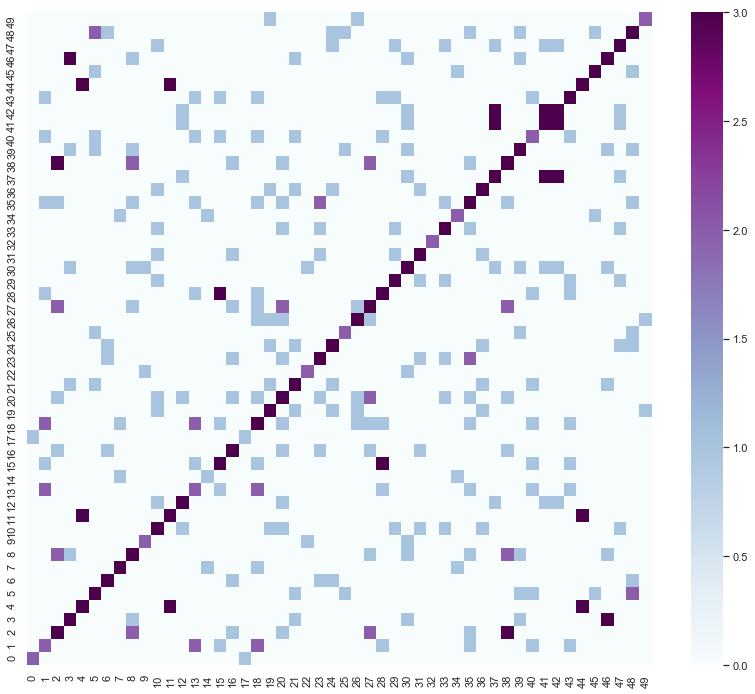

In [260]:
plot_feature_SSM(fm)
# question: 1. should we normalize?
#           2. should we set up a threshold?
#           3. maybe there is a analysis parameter that we can change

In [24]:
# compute audio features

In [70]:
def compute_mfcc(path, sr):
    '''
        Returns the mfcc feature for the given audio
    '''
    # read audio signal
    y, sr = librosa.load(path, sr=sr)

    # compute the mfcc
    mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=14, n_fft=2048, hop_length=1024)
    
    return mfcc

In [71]:
audio_path = 'data/vocals/Criminal/sponsor/vocals.wav'
mfcc_feature = compute_mfcc(audio_path, 44100)

In [72]:
mfcc_feature.shape

(14, 10157)

In [87]:
def plot_mfcc_SSM(mfcc):
    '''
        Plot the mfcc SSM
    '''
    mfcc_SSM = compute_SM_dot(mfcc, mfcc)
    print(mfcc_SSM.shape)
    sub_mfcc_ssm = mfcc_SSM[50:100,50:100]
    print(sub_mfcc_ssm)
    ax = sns.heatmap(sub_mfcc_ssm, vmin=-500000, vmax=500000, cmap='PiYG')
    ax.invert_yaxis()
    sns.set(rc={'figure.figsize':(14,12)})

(10157, 10157)
[[250423.95103132 251861.2698358  255015.81904007 ... 250469.69868067
  253995.50341639 250099.84484063]
 [251861.2698358  253498.97596158 256688.13956847 ... 252003.10737136
  255546.01733255 251631.4745221 ]
 [255015.81904007 256688.13956847 260130.60852729 ... 255156.52412534
  258947.58084755 254732.61169322]
 ...
 [250469.69868067 252003.10737136 255156.52412534 ... 250607.48393054
  254104.27366716 250223.98527432]
 [253995.50341639 255546.01733255 258947.58084755 ... 254104.27366716
  257866.19897467 253688.19622665]
 [250099.84484063 251631.4745221  254732.61169322 ... 250223.98527432
  253688.19622665 249928.50188076]]


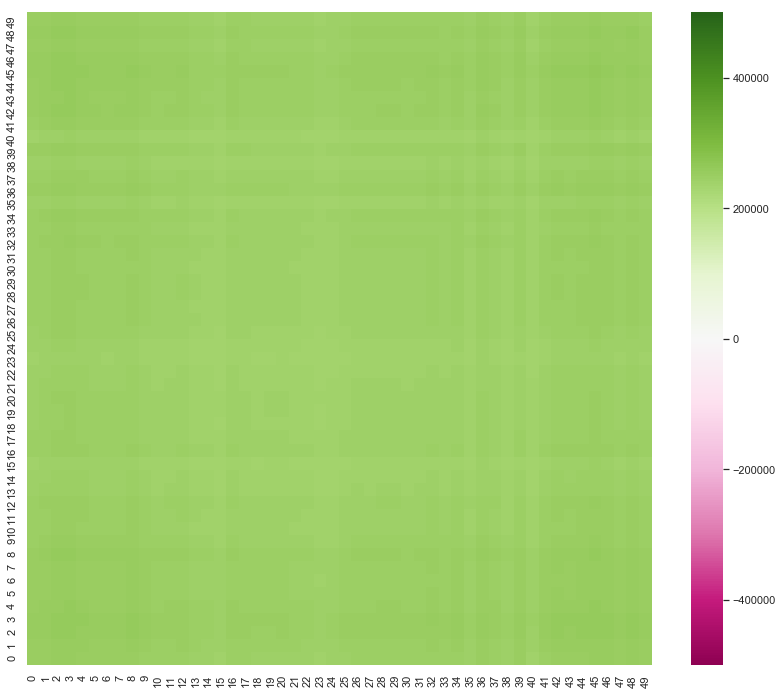

In [88]:
plot_mfcc_SSM(mfcc_feature)

In [89]:
def get_lower_half(SSM):
    '''
        Because of the redundancy of the SSM, we get the lower half of the matrix, excluding the diagonal
    '''
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-89-bb4e94739d2f>, line 1)